## The DaVinci Code

In [1]:
import os
import cv2
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
import pywt
from typing import Tuple
from skimage.restoration import denoise_wavelet, denoise_tv_chambolle

In [2]:
def load_image(folder: str, filename: str, grayscale: bool = True) -> np.ndarray:
    """
    Load an image from the given folder and filename using OS-independent paths.

    Parameters:
    - folder: Directory containing the image
    - filename: Image filename (e.g., 'image1.png')
    - grayscale: Load as grayscale or color (default: True)

    Returns:
    - Loaded image as a NumPy array
    """
    path = os.path.join(folder, filename)
    flag = cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR
    image = cv2.imread(path, flag)
    if image is None:
        raise FileNotFoundError(f"Could not load image at path: {path}")
    return image

In [3]:
def plote_images(images: list[np.ndarray], titles: list[str] = None, cmap: str = 'gray', figsize: tuple = (10, 5)):
    """
    Display multiple images side by side with optional titles.

    Parameters:
    - images: List of NumPy arrays representing the images.
    - titles: Optional list of titles for each image.
    - cmap: Colormap to use (default: 'gray' for grayscale).
    - figsize: Tuple for figure size.
    """
    n = len(images)
    if titles is None:
        titles = [f"Image {i+1}" for i in range(n)]
    if len(titles) != n:
        raise ValueError("Number of titles must match number of images.")

    plt.figure(figsize=figsize)
    
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap=cmap)
        plt.title(title)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [4]:
def plot_histogram(image: np.ndarray, title: str = "Normalized Intensity Histogram") -> None:
    """
    Plot normalized histogram of a grayscale image.
    
    Args:
        image (np.ndarray): Grayscale image.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 5))
    plt.hist(image.ravel(), bins=256, range=(0, 256), color='gray', density=True)
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Probability")
    plt.grid(True)
    plt.show()

In [9]:
# Smoothing Filters
def denoise_box_filter(image: np.ndarray, ksize: int = 3) -> np.ndarray:
    return cv2.blur(image, (ksize, ksize))

def denoise_gaussian_filter(image: np.ndarray, ksize: int = 5, sigma: float = 1.0) -> np.ndarray:
    return cv2.GaussianBlur(image, (ksize, ksize), sigma)

# Statistical Filters
def denoise_median_filter(image: np.ndarray, ksize: int = 5) -> np.ndarray:
    return cv2.medianBlur(image, ksize)

def denoise_max_filter(image: np.ndarray, ksize: int = 3) -> np.ndarray:
    return cv2.dilate(image, np.ones((ksize, ksize), np.uint8))

def denoise_min_filter(image: np.ndarray, ksize: int = 3) -> np.ndarray:
    return cv2.erode(image, np.ones((ksize, ksize), np.uint8))

# Advanced Filters
def denoise_bilateral_filter(image: np.ndarray) -> np.ndarray:
    return cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)

def denoise_nl_means(image: np.ndarray, h: int = 10) -> np.ndarray:
    return cv2.fastNlMeansDenoising(image, None, h, 7, 21)

def denoise_wavelet_filter(image: np.ndarray) -> np.ndarray:
    return denoise_wavelet(image, channel_axis=None, convert2ycbcr=False, rescale_sigma=True)

def denoise_total_variation(image: np.ndarray, weight: float = 0.1) -> np.ndarray:
    return denoise_tv_chambolle(image, weight=weight, channel_axis=None)

#### image 1: Denoising

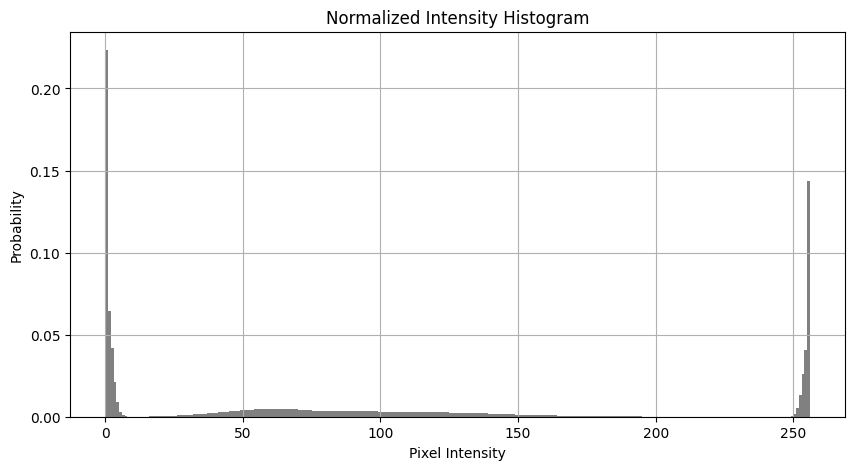

In [103]:
img1 = load_image("Q1", "processed_img_part_1.jpg")
plot_histogram(img1)

In [56]:
img_box = denoise_box_filter(img1)
img_box_larger = denoise_box_filter(img1, ksize = 15)
img_gaussian = denoise_gaussian_filter(img1)
img_gaussian_larger = denoise_gaussian_filter(img1, ksize = 15)

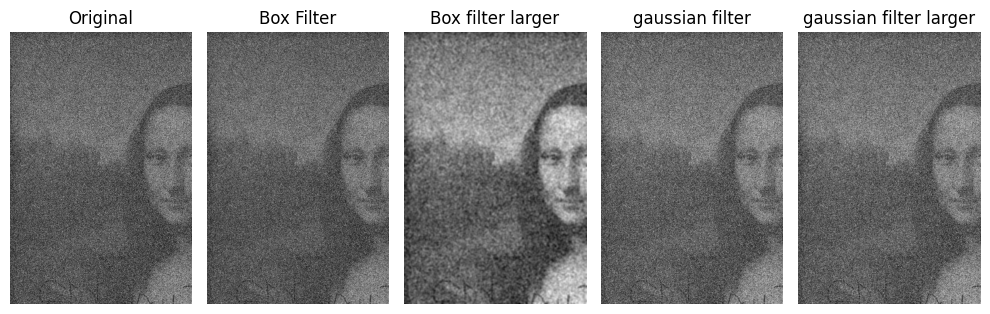

In [31]:
plote_images(
    [img1, img_box, img_box_larger, img_gaussian, img_gaussian_larger],
    titles=["Original", "Box Filter", "Box filter larger", "gaussian filter", "gaussian filter larger"]
)

In [33]:
img_bilateral = denoise_bilateral_filter(img1)
img_nlmeans = denoise_nl_means(img1)
img_wavelet = denoise_wavelet_filter(img1)
img_tv = denoise_total_variation(img1)

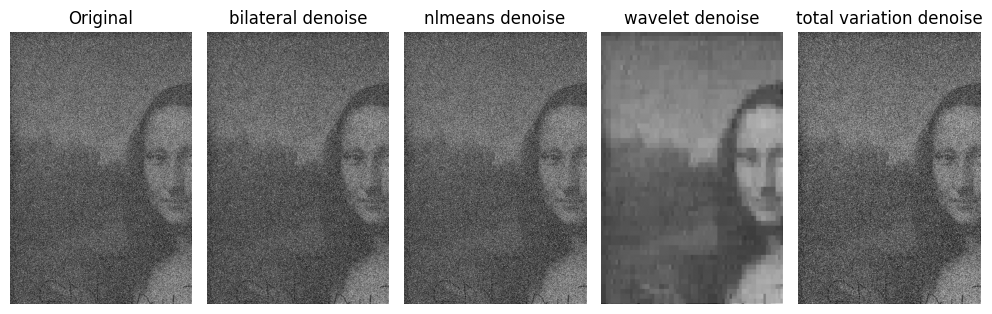

In [34]:
plote_images(
    [img1, img_bilateral, img_nlmeans, img_wavelet, img_tv],
    titles=["Original", "bilateral denoise", "nlmeans denoise", "wavelet denoise", "total variation denoise"]
)

In [37]:
img_max = denoise_max_filter(img1)
img_min = denoise_min_filter(img1)
img_median = denoise_median_filter(img1)
img_median_larger = denoise_median_filter(img1, ksize = 7)

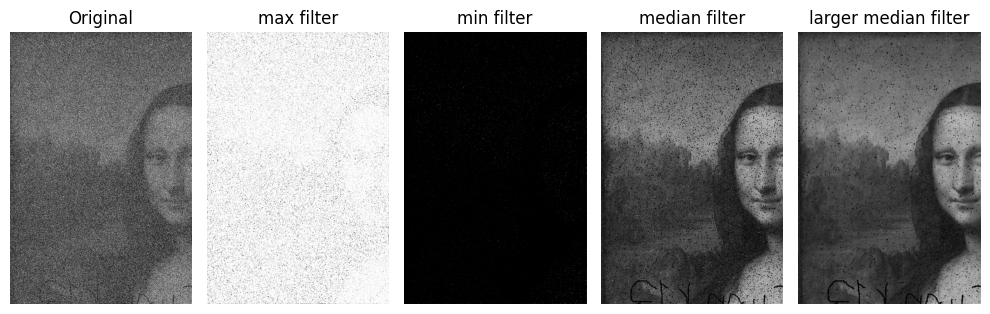

In [39]:
plote_images(
    [img1, img_max, img_min, img_median, img_median_larger],
    titles=["Original", "max filter", "min filter", "median filter", "larger median filter"]
)

In [23]:
def compute_fft_components(image: np.ndarray) -> tuple:
    """
    Compute the FFT components: log-magnitude and phase of a grayscale image.
    Returns normalized versions for display.
    """
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)

    # magnitude = np.log(np.abs(fshift)**2 + 1)
    # magnitude = np.log1p(np.abs(fshift))
    magnitude = 20 * np.log(np.abs(fshift) + 1)
    phase = np.angle(fshift)

    mag_norm = normalize_img(magnitude)
    phase_norm = normalize_img(phase)

    return mag_norm, phase_norm

In [27]:
def normalize_img(img: np.ndarray) -> np.ndarray:
    """
    Normalize image to [0, 1] for visualization.
    """
    return (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)

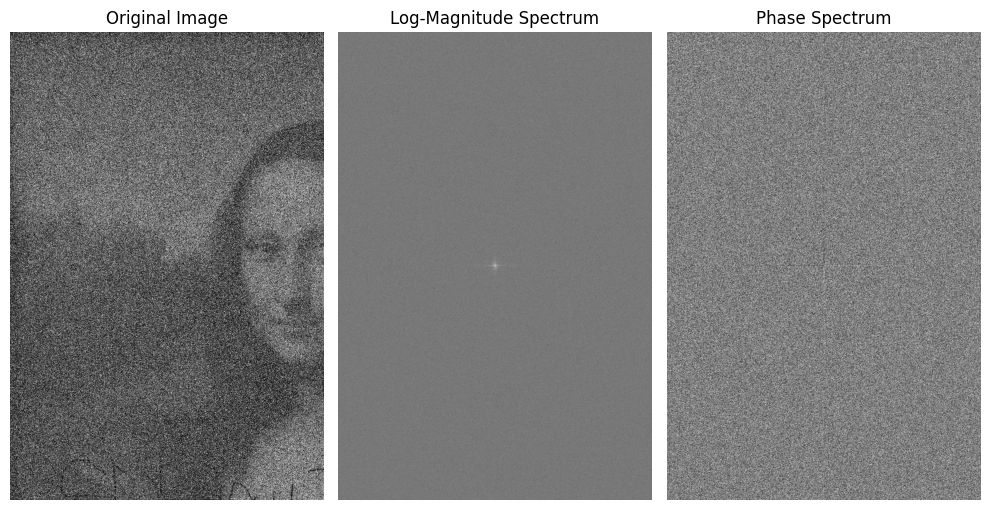

In [45]:
# Compute FFT components
log_mag, phase = compute_fft_components(img1)

# Visualize
plote_images(
    [img1, log_mag, phase],
    titles=["Original Image", "Log-Magnitude Spectrum", "Phase Spectrum"]
)

In [47]:
img_median = denoise_median_filter(img1)
img_median_2 = denoise_median_filter(img_median)
img_median_3 = denoise_median_filter(img_median_2)
img_median_4 = denoise_median_filter(img_median_3)

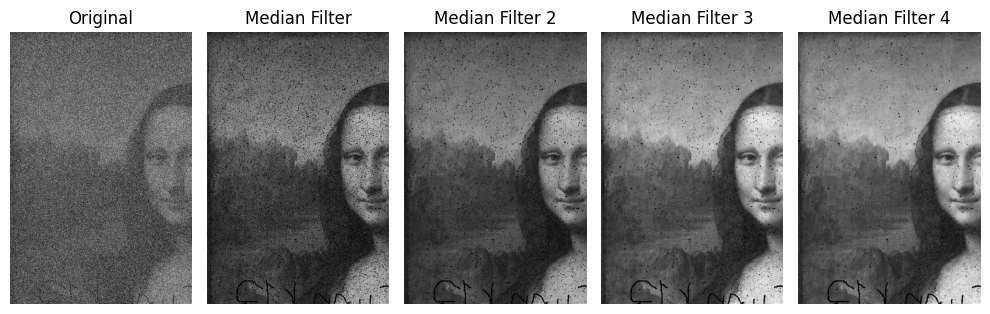

In [49]:
plote_images(
    [img1, img_median, img_median_2, img_median_3, img_median_4],
    titles=["Original", "Median Filter", "Median Filter 2", "Median Filter 3", "Median Filter 4"]
)

In [107]:
median_larger_kernel = denoise_median_filter(img1, ksize = 15)

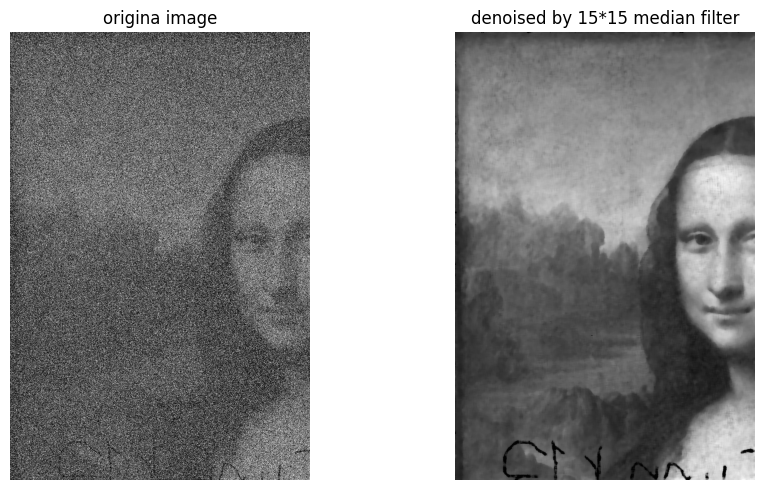

True

In [109]:
plote_images(
    [img1, median_larger_kernel],
    titles=["origina image", "denoised by 15*15 median filter"]
)

cv2.imwrite("img1.png", median_larger_kernel)

---

## image 2: domain change + denoising

In [86]:
def create_band_reject_mask(shape: Tuple[int, int], radius: float, width: float) -> np.ndarray:
    """
    Create a circular band-reject mask for filtering frequencies in FFT domain.
    """
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    Y, X = np.ogrid[:rows, :cols]
    dist = np.sqrt((X - ccol)**2 + (Y - crow)**2)

    # Keep everything except this ring
    mask = np.logical_or(dist <= radius - width/2, dist >= radius + width/2)
    return mask.astype(np.float32)


In [29]:
def inverse_low_freq_fft(image: np.ndarray, radius: int = 45) -> np.ndarray:
    """
    Applies a low-pass filter in frequency domain, then inverse FFT.
    """
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)

    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros_like(image, dtype=np.uint8)
    mask[crow - radius:crow + radius, ccol - radius:ccol + radius] = 1

    f_filtered = fshift * mask
    img_back = np.fft.ifft2(np.fft.ifftshift(f_filtered))
    return np.abs(img_back)


In [94]:
def compute_power_spectrum(image: np.ndarray) -> np.ndarray:
    """
    Compute the power spectrum of an image using FFT.
    Returns: 2D array of power values.
    """
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    power = np.abs(fshift) ** 2
    return power

def format_log_power(power: np.ndarray) -> np.ndarray:
    """
    Convert power spectrum to log scale (for display).
    """
    return 10 * np.log10(power + 1e-8)

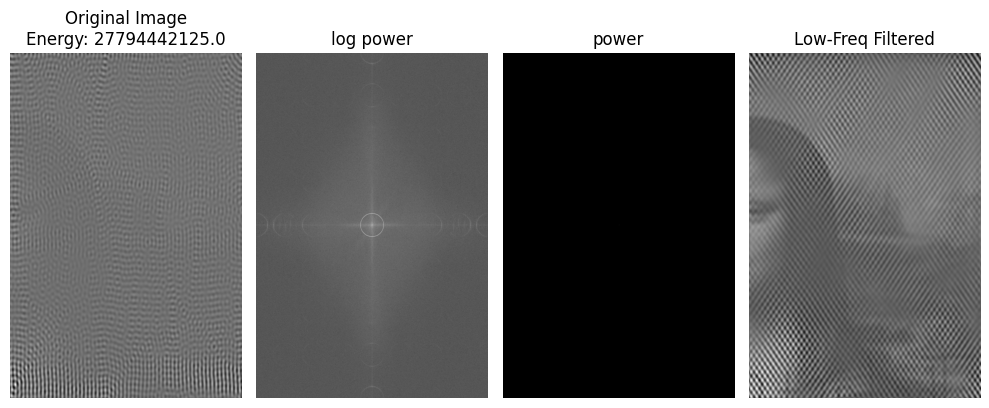

In [98]:
# Try all domains
inv_lowfreq = inverse_low_freq_fft(image)
energy = compute_energy(image)

# Compute power and log power
power = compute_power_spectrum(image)
log_power = format_log_power(power)

# Compare
plote_images(
    [image, log_power, power, inv_lowfreq],
    [f"Original Image\nEnergy: {energy:.1f}", "log power", "power", "Low-Freq Filtered"]
)


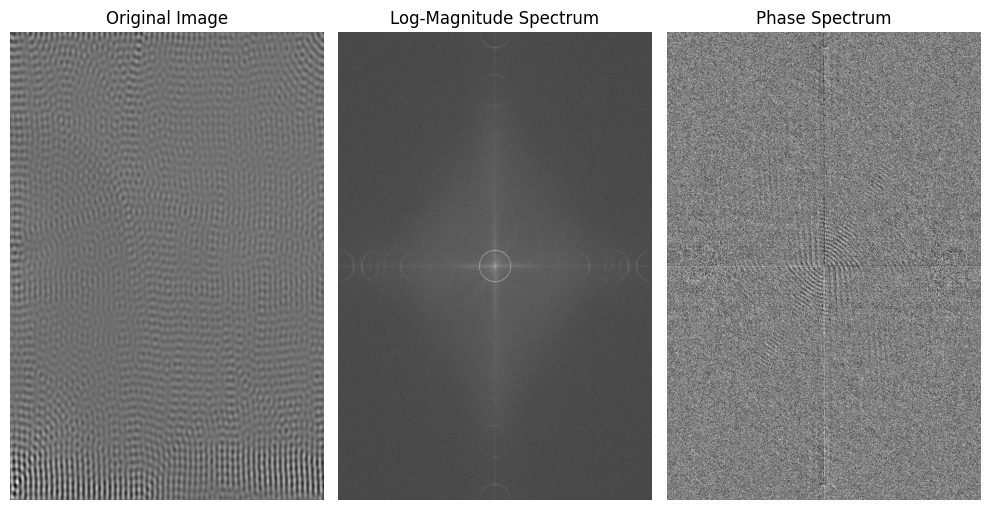

In [100]:
# Compute FFT components
log_mag, phase = compute_fft_components(image)

# Visualize
plote_images(
    [image, log_mag, phase],
    titles=["Original Image", "Log-Magnitude Spectrum", "Phase Spectrum"]
)

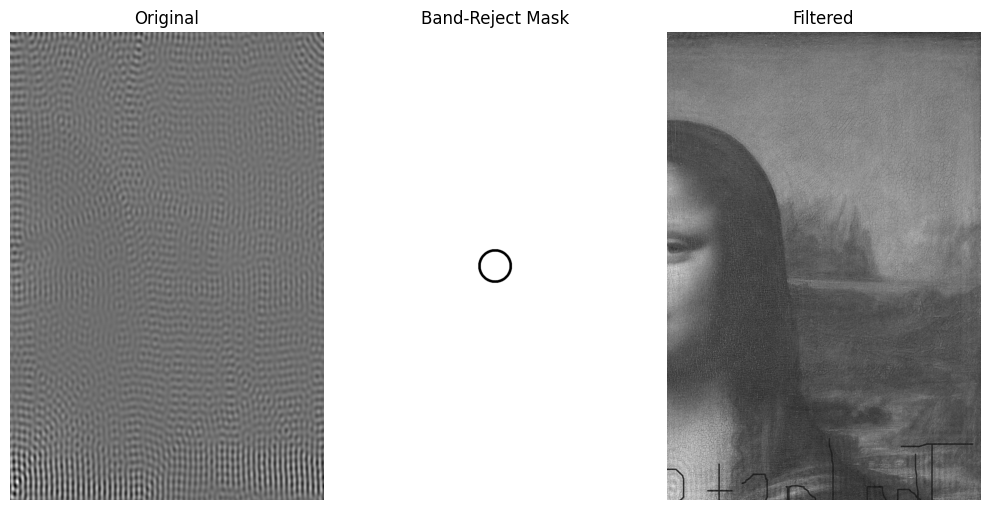

True

In [106]:
# 1. FFT
f = np.fft.fft2(image)
fshift = np.fft.fftshift(f)

# 2. Mask
mask = create_band_reject_mask(image.shape, radius=60, width=10)
f_filtered = fshift * mask
 
# 3. Inverse FFT
img_back = np.abs(np.fft.ifft2(np.fft.ifftshift(f_filtered)))

# 4. Show results
plote_images(
    [image, mask*255, img_back],
    ["Original", "Band-Reject Mask", "Filtered"]
)

img_back_uint8 = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX)
img_back_uint8 = img_back_uint8.astype(np.uint8)

# Save image
cv2.imwrite("img2.png", img_back_uint8)

---

## image 3: reconstrcution

In [64]:
def plot_laplacian_histograms_normalized(levels, bins=256, range_=(-128, 128), offset=128):
    """
    Plots normalized histograms (PDFs) of Laplacian pyramid levels.

    Parameters:
        levels: list of 2D numpy arrays
        bins: number of histogram bins
        range_: value range for histogram
        offset: offset added during saving (e.g., 128)
    """
    colors = ['blue', 'orange', 'green', 'red', 'purple']
    plt.figure(figsize=(10, 5))

    for i, lvl in enumerate(levels):
        if lvl.dtype == np.uint8:
            data = lvl.astype(np.float32) - offset
        else:
            data = lvl

        # Compute normalized histogram (PDF)
        hist, bin_edges = np.histogram(data.flatten(), bins=bins, range=range_, density=True)
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

        plt.plot(bin_centers, hist, color=colors[i % len(colors)], label=f"Level {i}")

    plt.title("Normalized Laplacian Pyramid Histograms (PDF)")
    plt.xlabel("Residual Value")
    plt.ylabel("Probability Density")
    plt.legend()
    plt.grid(True)
    plt.show()


In [66]:
img_level = [None for i in range(5)]
img_level[0] = load_image("Q1", "processed_img_part_3_Level_0.jpg")
img_level[1] = load_image("Q1", "processed_img_part_3_Level_1.jpg")
img_level[2] = load_image("Q1", "processed_img_part_3_Level_2.jpg")
img_level[3] = load_image("Q1", "processed_img_part_3_Level_3.jpg")
img_level[4] = load_image("Q1", "processed_img_part_3_Level_4.jpg")

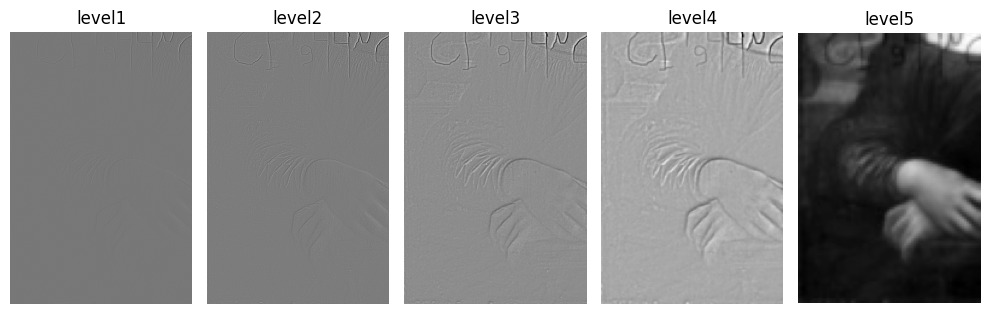

In [43]:
plote_images(
    [img_level[0], img_level[1], img_level[2], img_level[3], img_level[4]],
    titles=["level1", "level2", "level3", "level4", "level5"]
)

In [68]:
sizes = [None for i in range(5)] 
for i in range(5):
    sizes[i] = img_level[i].shape[0], img_level[i].shape[1]

sizes

[(1796, 1201), (898, 601), (449, 301), (225, 151), (113, 76)]

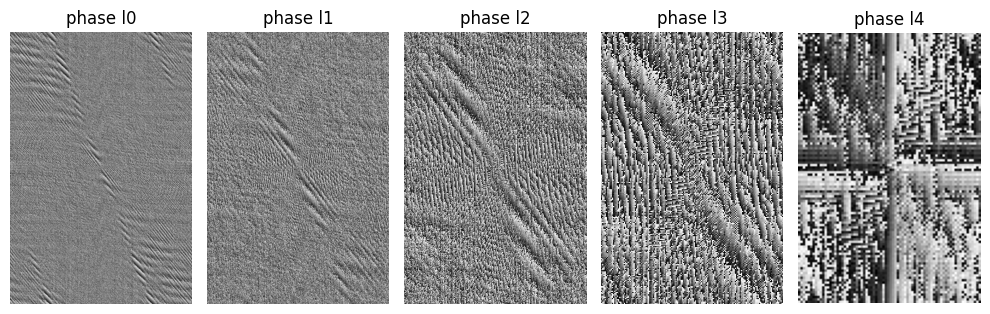

In [70]:
log_img_level = [0 for i in range(5)]
phase_img_level = [0 for i in range(5)]
for i in range(5):
    log_img_level[i], phase_img_level[i] = compute_fft_components(img_level[i])

plote_images(
    [phase_img_level[0], phase_img_level[1], phase_img_level[2], phase_img_level[3], phase_img_level[4]],
    titles=["phase l0", "phase l1", "phase l2", "phase l3", "phase l4"]
)

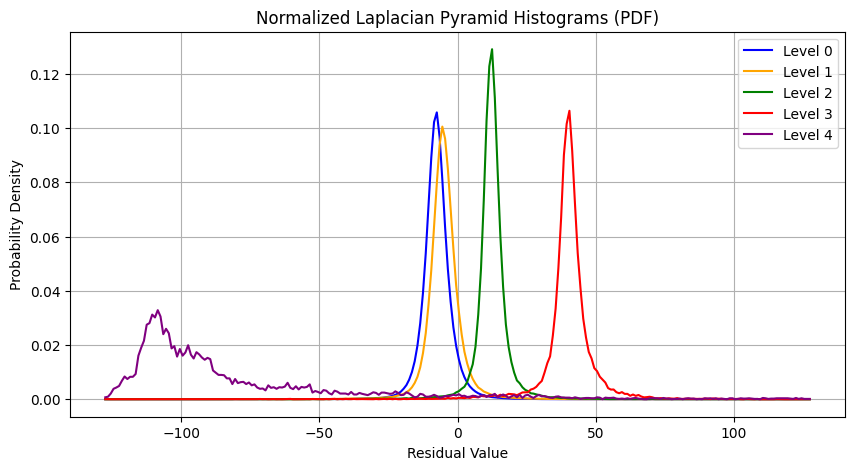

In [131]:
plot_laplacian_histograms_normalized(img_level)

In [72]:
def upsample(image, target_shape):
    return cv2.resize(image, (target_shape[1], target_shape[0]), interpolation=cv2.INTER_LINEAR)

def reconstruct_from_pyramid(pyramid_levels):
    reconstructed = pyramid_levels[4]  
    for i in reversed(range(4)):       # Add Level 4 → 3 → 2 → 1 → 0
        print(i)
        up = upsample(reconstructed, pyramid_levels[i].shape)
        reconstructed = up + pyramid_levels[i]
    return reconstructed

In [74]:
reconstructed = reconstruct_from_pyramid(img_level)

3
2
1
0


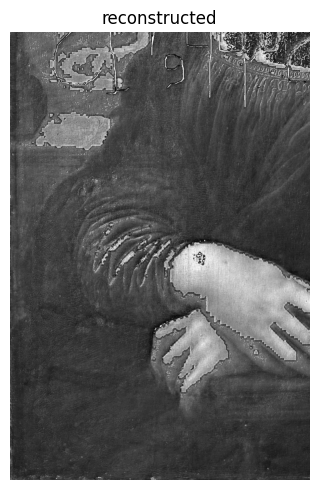

In [155]:
plote_images(
    [reconstructed],
    titles=["reconstructed"]
)

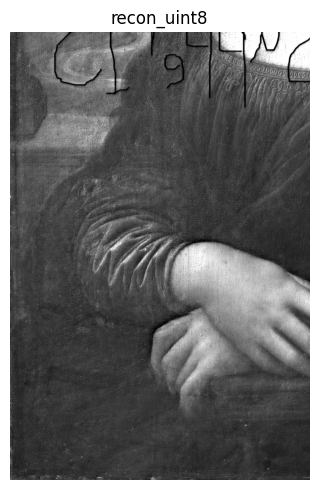

True

In [229]:
def load_level_costume(path, is_base=False):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    if not is_base:
        # undo the +128 offset you used for display
        img = img - 128.0
    return img

levels = []
for i in range(4):
    levels.append(load_level_costume(f"Q1/processed_img_part_3_Level_{i}.jpg", is_base=False))
# level 4 is the coarsest approximation (no offset)
levels.append(load_level_costume("Q1/processed_img_part_3_Level_4.jpg", is_base=True))

recon = levels[-1]
for lvl in reversed(levels[:-1]):
    recon = cv2.resize(recon, (lvl.shape[1], lvl.shape[0]), interpolation=cv2.INTER_LINEAR)
    recon = recon + lvl

# 3) clip back into display range
recon_uint8 = np.clip(recon, 0, 255).astype(np.uint8)
# cv2.imwrite("reconstructed_fixed.png", recon_uint8)

plote_images(
    [recon_uint8],
    titles=["recon_uint8"]
)

cv2.imwrite("img4.png", recon_uint8)

---

## part 4: image color reformating

In [13]:
def plot_rgb_histograms(image: np.ndarray) -> None:
    """
    Plot histograms for R, G, B channels of a color image.
    """
    colors = ('b', 'g', 'r')
    plt.figure(figsize=(10, 4))
    for i, color in enumerate(colors):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(hist, color=color, label=f"{color.upper()} channel")
    plt.title("RGB Channel Histograms")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_hsv_components(image: np.ndarray) -> None:
    """
    Plot HSV component images and their histograms.
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    names = ['Hue', 'Saturation', 'Value']
    data = [h, s, v]

    # Show component images
    plote_images(data, names, cmap='gray', figsize=(12, 4))

    # Show histograms
    plt.figure(figsize=(10, 4))
    for comp, name, color in zip(data, names, ['m', 'c', 'y']):
        hist = cv2.calcHist([comp], [0], None, [256], [0, 256])
        plt.plot(hist, color=color, label=name)
    plt.title("HSV Component Histograms")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [15]:
def extract_rgb_channels(image: np.ndarray) -> dict:
    """
    Extract RGB channels from a color image as separate grayscale images.

    Parameters:
    - image: BGR color image (OpenCV default)

    Returns:
    - A dictionary with keys 'r', 'g', 'b', each mapped to a grayscale image
    """
    b, g, r = cv2.split(image)
    return {'r': r, 'g': g, 'b': b}


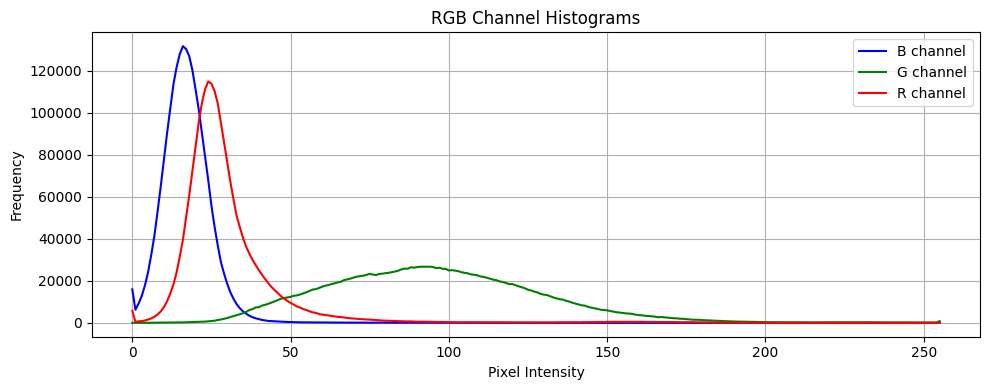

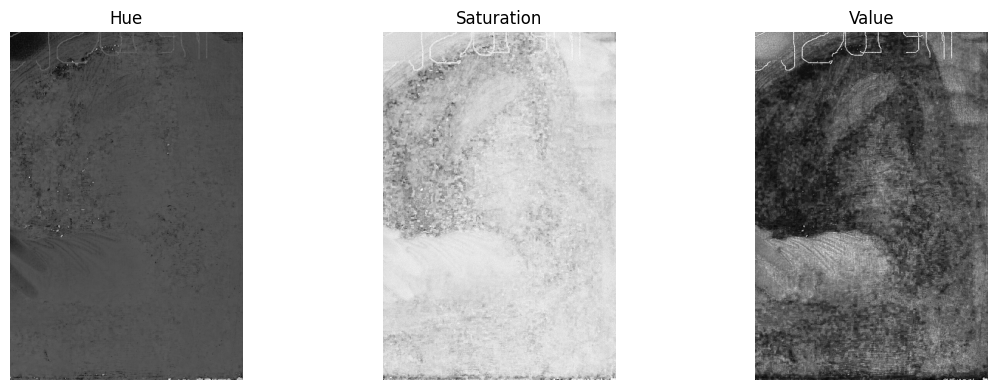

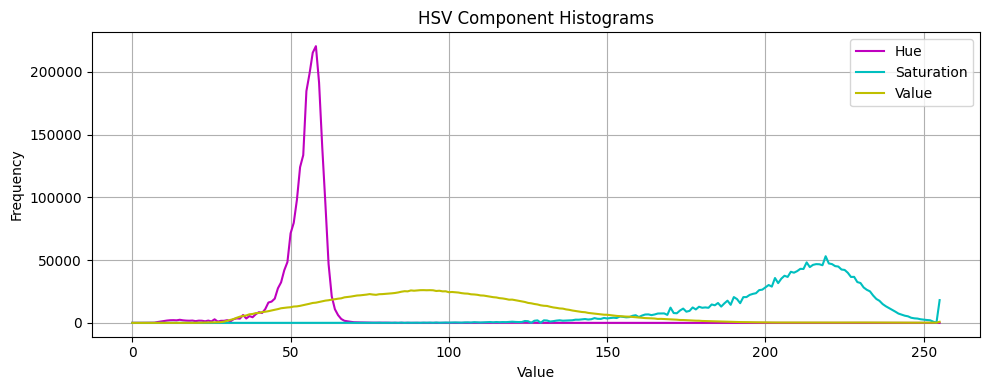

In [17]:
image = load_image("Q1", "processed_img_part_4.jpg", grayscale=False)

plot_rgb_histograms(image)

plot_hsv_components(image)

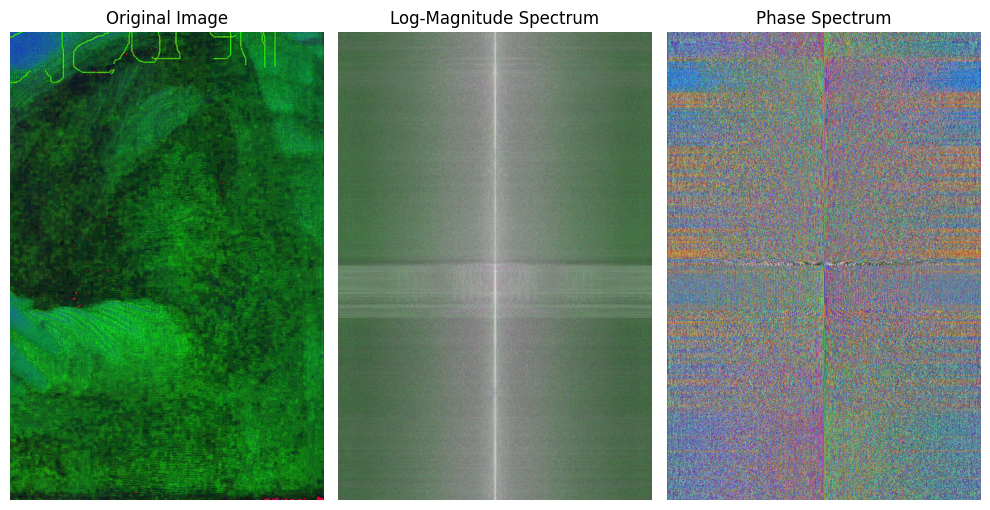

In [29]:
# 1. Load image
image = load_image("Q1", "processed_img_part_4.jpg", grayscale=False)

log_mag, phase = compute_fft_components(image)

plote_images(
    [image, log_mag, phase],
    titles=["Original Image", "Log-Magnitude Spectrum", "Phase Spectrum"]
)

In [31]:
def create_vertical_line_mask(shape: Tuple[int, int], x_center: int, width: int) -> np.ndarray:
    """
    Create a vertical notch (reject) mask to block a vertical line in the frequency spectrum.

    Parameters:
    - shape: (height, width) of the image
    - x_center: horizontal center position (e.g., cols // 2)
    - width: width of the vertical stripe to block

    Returns:
    - mask: A binary mask with 0 along the vertical band to suppress, 1 elsewhere
    """
    rows, cols = shape
    mask = np.ones((rows, cols), dtype=np.float32)
    left = max(0, x_center - width // 2)
    right = min(cols, x_center + width // 2)
    mask[:, left:right] = 0
    return mask


In [33]:
def fft_vertical_notch_filter(image: np.ndarray, x_center: int = None, width: int = 6) -> np.ndarray:
    """
    Remove vertical frequency interference via FFT-based notch filtering.
    """
    if x_center is None:
        x_center = image.shape[1] // 2

    # FFT and shift
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)

    # Mask vertical frequency band
    mask = create_vertical_line_mask(image.shape, x_center=x_center, width=width)
    f_filtered = fshift * mask

    # Inverse FFT and normalize
    img_back = np.abs(np.fft.ifft2(np.fft.ifftshift(f_filtered)))
    img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    return img_back, mask

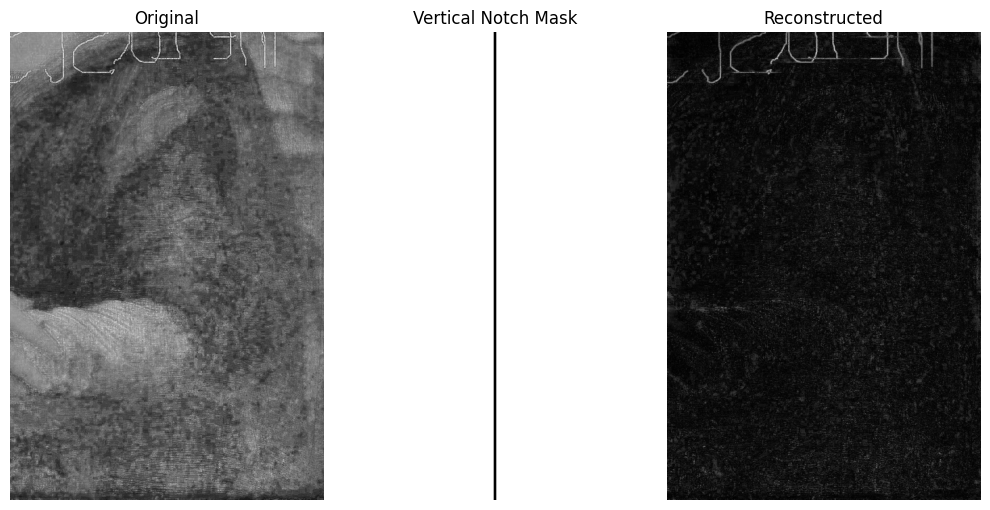

In [35]:
image = load_image("Q1", "processed_img_part_4.jpg", grayscale=True)
recovered_img, mask = fft_vertical_notch_filter(image, width=10)

plote_images(
    [image, mask * 255, recovered_img],
    ["Original", "Vertical Notch Mask", "Reconstructed"]
)

In [37]:
cv2.imwrite("img4.png", recovered_img)

True

## finilize and concat images

In [42]:
import cv2
import numpy as np
from pathlib import Path

def hstack_resize_to_same_height(imgA, imgB):
    """Resize second image to match first image's height, then hstack."""
    hA = imgA.shape[0]
    hB, wB = imgB.shape[:2]
    scale = hA / hB
    imgB_resized = cv2.resize(imgB, (int(wB*scale), hA), interpolation=cv2.INTER_AREA)
    return np.hstack([imgA, imgB_resized])

def add_padding(img, pad, color=(255,255,255)):
    if pad <= 0: return img
    top = bottom = left = right = pad
    return cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

def make_2x2_grid(p1, p2, p3, p4, spacing=8, bg=(255,255,255), out_path="grid.png"):
    # load
    i1 = cv2.imread(p1); i2 = cv2.imread(p2); i3 = cv2.imread(p3); i4 = cv2.imread(p4)
    if any(x is None for x in [i1,i2,i3,i4]):
        raise FileNotFoundError("One of the input images was not found.")

    # build top and bottom rows (resize i2 to i1's height; i4 to i3's height)
    top = hstack_resize_to_same_height(i1, i2)
    bot = hstack_resize_to_same_height(i3, i4)

    # pad rows with spacing
    top = add_padding(top, spacing//2, bg)
    bot = add_padding(bot, spacing//2, bg)

    # resize bottom row width to match top row width (if needed)
    if bot.shape[1] != top.shape[1]:
        scale = top.shape[1] / bot.shape[1]
        bot = cv2.resize(bot, (top.shape[1], int(bot.shape[0]*scale)), interpolation=cv2.INTER_AREA)

    # stack rows with spacing bar
    spacer = np.full((spacing, top.shape[1], 3), bg, dtype=np.uint8) if spacing>0 else np.zeros((0, top.shape[1], 3), np.uint8)
    grid = np.vstack([top, spacer, bot])

    cv2.imwrite(out_path, grid)
    return out_path, grid

# ---- Example usage
out_path, grid = make_2x2_grid("img1.png", "img2.png", "img3.png", "img4.png",
                               spacing=12, bg=(255,255,255), out_path="grid_2x2.png")
print("Saved to:", out_path)


Saved to: grid_2x2.png


In [71]:
FlipMode = Literal["horizontal", "vertical", "both"]

def mirror_image(src, flip, out_path=None):
    # load image
    if isinstance(src, (str, Path)):
        img = cv2.imread(str(src), cv2.IMREAD_COLOR)
        if img is None:
            raise FileNotFoundError(f"Could not read: {src}")
    else:
        img = src

    flip_map = {"horizontal": 1, "vertical": 0, "both": -1}
    if flip not in flip_map:
        raise ValueError("flip must be 'horizontal', 'vertical', or 'both'")
    out = cv2.flip(img, flip_map[flip])

    if out_path is not None:
        cv2.imwrite(str(out_path), out)

    rgb     = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    rgb_out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1); plt.imshow(rgb);     plt.title("Original");            plt.axis("off")
    plt.subplot(1, 2, 2); plt.imshow(rgb_out); plt.title(f"Mirrored ({flip})");  plt.axis("off")
    plt.tight_layout()
    plt.show()

    return out

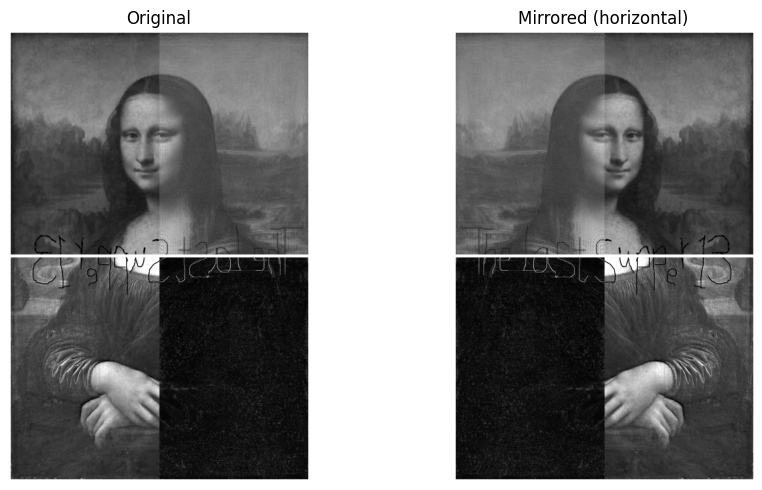

In [73]:
out = mirror_image("grid_2x2.png",
                 flip="horizontal",
                 out_path="mirrored_code.png")

### THE LAST SUPPER: the Jesus image by da vin ci, the 13'th person is considered Jesus!